# Recommender Systems - Mini Challenge HS24

In this minichallenge we will explore a MovieLens dataset and implement several recommender systems and evaluation methods. Subsequently we will optimize these methods and compare the results. 

**Submission deadline:** 24.11.2024 18:00. 

## Guidelines for Implementation and Submission
- Code must be written in Python. The versions of all used packages must be given for reproducability.
- You may respond in English or German.
- We develop numerous algorithms ourselves. Unless explicitly stated otherwise, only the following libraries may be used in Python: numpy, matplotlib, seaborn, pandas. 
- Follow good coding practices and write modular, reusable code.
- The submitted solution must contain all codes and the results. No code may be outsourced.
- All pathes must be relative and just downloading your repo must be executable without modifications.
- Only fully running code is graded. The notebook must run sequential from start to end.
- If computation time is too long for productive prototyping and debugging work, it is recommended to reduce the dataset to a fraction of its original. However, final results should be calculated on the full dataset. 
- All plots must be fully labeled (title, axes, labels, colorbar, etc.) so that the plot can be easily understood.
- Each plot should be accompanied by a brief discussion, which explains the plot and captures the key insights that become visible.
- Only fully labeled plots with an accompanying discussion will be assessed.
- The last commit in your fork of the repo before the submission deadline counts as the submission.
- Points will be deducted if you write inconsise (Denial of service will be punished) or if I read the text that are not written for me but for the user of ChatGPT. 
- If you would like to submit and have the mini-challenge assessed, please send a short email to the subject expert (moritz.kirschmann@fhnw.ch) within 2 days after submission.
- Please do not delete, duplicate, or move the existing cells. This leads to problems during the correction. However, you may add as many additional cells as you like.

## Exercises

### Exercise 1 - A deep exploration of the dataset (17 points)
We will work with a subset of the MovieLens dataset. This subset is located under ``data/ml-latest-small``. Read the ``README.txt``carefully. 
Open the files. 

a) Describe the available data.

Die Daten von MovieLens, einem Filmempfehlungsdienst, beschreiben 5-Sterne-Bewertungen von Filmen. Er enthält 100’836 Bewertungen und 3’683 Tags-Anwendungen für 9’742 Filme. Diese Daten wurden von 610 Nutzern zwischen dem 29. März 1996 und dem 24. September 2018 erstellt. Der Datensatz wurde am 26. September 2018 erstellt.
Die Nutzer wurden nach dem Zufallsprinzip für die Aufnahme ausgewählt. Alle ausgewählten Nutzer hatten mindestens 20 Filme bewertet. Es sind keine demografischen Informationen enthalten. Jeder Nutzer wird durch eine ID repräsentiert, und es werden keine weiteren Informationen bereitgestellt.
Die Daten sind in den Dateien «links.csv», «movies.csv», «ratings.csv» und «tags.csv» enthalten. 
Die Daten:
•	ratings.csv: Enthält alle Bewertungen. Jede Zeile repräsentiert eine Bewertung eines Films durch einen Benutzer und hat das Format: «userId», «movieId», «rating» und «timestamp». Die Bewertungen erfolgen auf einer 5-Sterne-Skala mit Abstufungen von einem halben Stern (0,5 Sterne - 5,0 Sterne).
•	tags.csv: Enthält alle tags (Etikett). Jede Zeile repräsentiert ein tag, das von einem Benutzer auf einen Film angewendet wurde, und hat das Format: «userId», «movieId», «tag» und «timestamp». Tags sind vom Benutzer erstellte Metadaten zu Filmen, wie beispielsweise der Hauptdarsteller oder ein Wort das beschreibt um was es im Gilm geht (bsp. Wedding wenn im Film geheiratet wird).
•	movies.csv: Enthält Filminformationen. Jede Zeile repräsentiert einen Film und hat das Format: «movieId», «title» und «genres». Die Genres sind eine durch Pipes ( | ) getrennte Liste, welche genres vom Film alles abgedeckt werden.
•	links.csv: Enthält Bezeichner zur Verknüpfung mit anderen Quellen von Filmdaten. Jede Zeile repräsentiert einen Film und hat das Format: «movieId», «imdbId» (imbdId = Internet Movie Database ID) und «tmdbId» (tmdbid = The Movie Database ID). Diese IDs helfen dabei, einen Film eindeutig auf verschiedenen Plattformen zu identifizieren. Wenn man also eine bestimmte Filminformation abrufen möchte, kann man die jeweilige ID nutzen, um den Film auf einer der Plattformen zu finden.

Programmiertechnisch wird der Datensatz im Abschnitt unter dem Markdown "a) Describe the available data" gezeigt.


b) Find and fix bad data (e.g. duplicates, missing values, etc.).

Generate lists of

c) - Top 20 movies by average rating

d) - Top 20 movies by number of views

e) What is the range of the ratings? 

f) Which genre has be rated how many times?

g) How sparse is the User Rating Matrix?

Plot the following:

h) How many users have rated how many movies

i) Which rating is given how often on average

j) Which rating is given how often on average per genre

k) The rating distributions of 10 random movies

l) The rating distributions of 3 movies that you have watched

m) How many users give which average rating

n) How often a movie was rated as a function of average rating

o) A heatmap of the User Item Matrix

p) A heatmap of the User Item Matrix for the 100 most rated movies for the 50 users with most ratings


## Abklären ob diese libs gehen

In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
#Damit die Liste im Output besser aussieht brauche ich pprint
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Damit die Liste im Output besser aussieht brauche ich pprint

## Datensätze werden zum ersten Mal eingelesen

In [ ]:
#Datensätze einlesen
output_dir = Path("Data\ml-latest-small")
csv_path_links = output_dir / "links.csv"
csv_path_movies = output_dir / "movies.csv"
csv_path_ratings = output_dir / "ratings.csv"
csv_path_tags = output_dir / "tags.csv"
links_raw = pd.read_csv(csv_path_links)
movies_raw = pd.read_csv(csv_path_movies)
ratings_raw = pd.read_csv(csv_path_ratings)
tags_raw = pd.read_csv(csv_path_tags)

## a) Describe the available data.

In [ ]:
#Aufgabe A
def data_describe(df, name):
    print(f"{name} Datensatz")
    print("\n Info")
    pprint.pprint(df.info())
    print("\n Head")
    pprint.pprint(df.head())

data_describe(links_raw, "links")

In [ ]:
data_describe(movies_raw, "movies")

In [ ]:
data_describe(ratings_raw, "ratings")

In [ ]:
data_describe(tags_raw, "tags")

## b) Find and fix bad data (e.g. duplicates, missing values, etc.)

In [ ]:
#Aufgabe B
# Pfade der Datensätze um sicherzugehen, dass ich die nehme, die noch unberührt sind
files = {
    "links": "Data/ml-latest-small/links.csv",
    "movies": "Data/ml-latest-small/movies.csv",
    "ratings": "Data/ml-latest-small/ratings.csv",
    "tags": "Data/ml-latest-small/tags.csv",
}

# Funktion zur Bereinigung und Standardisierung von CSV-Daten
def clean_dataframe(df):
    # Entfernen von unnötigen Anführungszeichen, die den gesamten Wert umschliessen, da mir auffiel, dass es im Datensatz Movies dieses Problem gab
    def clean_string(x):
        if isinstance(x, str):
            # Entfernen von führenden und nachfolgenden Anführungszeichen
            x = x.strip("'\"")
        return x

    df = df.map(clean_string)
    
    # mögliche "<unset>" durch NaN ersetzen
    df = df.replace("<unset>", np.nan)
    
    # Überprüfen und Anpassen des Datentyps
    for column in df.columns:
        # Versuchen, den Datentyp zu inferieren und zu casten, falls der Datentyp nicht konsistent ist
        if df[column].dtype == 'object':
            # Überprüfen, ob die Spalte nur numerische Werte enthält
            try:
                df[column] = pd.to_numeric(df[column], errors='raise')
            except ValueError:
                pass  # Wenn es nicht konvertierbar ist, behalten wir den ursprünglichen Datentyp bei
    
    return df

# Lade Daten in DataFrames und stelle sicher, dass die erste Zeile als Spaltennamen verwendet wird
dfs = {}
for name, path in files.items():
    df = pd.read_csv(path, header=None)
    
    # Setze die erste Zeile als Spaltennamen
    df.columns = df.iloc[0]
    
    # Entferne die erste Zeile, da sie jetzt die Spaltenüberschriften sind
    df = df.drop(0, axis=0).reset_index(drop=True)
    
    dfs[name] = df

# Anwenden der Reinigung auf alle DataFrames
dfs_cleaned = {name: clean_dataframe(df) for name, df in dfs.items()}

# Zielordner definieren um die neuen DF von den alten getrennt zu speichern
output_dir = "Data/filtered_data"

# Sicherstellen, dass der Zielordner existiert
os.makedirs(output_dir, exist_ok=True)

for name, df in dfs_cleaned.items():
    # Berechnen der Anzahl der Duplikate und NA aus den gefilterten Daten um zu zeigen, dass sie gut gefiltert wurden
    duplicates_count = df.duplicated().sum()
    na_count = df.isna().sum()
    # Ausgabe der Anzahl der Duplikate
    print(f"Anzahl der Duplikate im {name}-Datensatz: {duplicates_count}\n")
    # Ausgabe der Anzahl der NA
    print(f"Anzahl der NA im {name}-Datensatz: {na_count}\n")
    
    # Speichern der bereinigten DataFrames als CSV-Dateien
    df.to_csv(os.path.join(output_dir, f"{name}_cleaned.csv"), index=False)

print("Bereinigte Daten wurden gespeichert.")

In [51]:
#Gefilterte Datensätze wieder den Variablen zuweisen:
output_dir = Path("Data/filtered_data")
csv_path_links = output_dir / "links_cleaned.csv"
csv_path_movies = output_dir / "movies_cleaned.csv"
csv_path_ratings = output_dir / "ratings_cleaned.csv"
csv_path_tags = output_dir / "tags_cleaned.csv"
links = pd.read_csv(csv_path_links)
movies = pd.read_csv(csv_path_movies)
ratings = pd.read_csv(csv_path_ratings)
tags = pd.read_csv(csv_path_tags)

## c) Generate a lis of Top 20 movies by average rating

In [ ]:
#gruppiert die Filme und berechnet den Bewertungsdurchschnitt. Zusätzlich, nehme ich nur die höchsten 20 und wandle es zu einem DF um, damit ich es mergen kann
top_20_movies = ratings.groupby("movieId")["rating"].mean().sort_values(ascending=False).head(20).reset_index()

liste_top_20 = list(top_20_movies.merge(movies[["movieId", "title"]], on="movieId", how="left")["title"])
pprint.pprint(liste_top_20)

## d) Generate a list of Top 20 movies by number of views
Ich gehe hier davon aus, dass ein view einer Bewertung entspricht, da ein Film für eine Bewertung zumindest einmal gesehen werden muss.

In [ ]:
#gruppiert die Filme und summiert die ANzahl Bewertungen. Zusätzlich, nehme ich nur die höchsten 20 und wandle es zu einem DF um, damit ich es mergen kann
top_20_movies_by_view = ratings.groupby("movieId")["rating"].count().sort_values(ascending=False).head(20).reset_index()

liste_top_20_by_view = list(top_20_movies_by_view.merge(movies[["movieId", "title"]], on="movieId", how="left")["title"])
pprint.pprint(liste_top_20_by_view)

## e) What is the range of the ratings?

In [ ]:
list_of_ratings = ratings["rating"].drop_duplicates().sort_values(ascending=False).tolist()
print(f"Die Spannweite der Bewertungen für die Filme liegt zwischen: {list_of_ratings[-1]} bis {list_of_ratings[0]}")

## f) Which genre has be rated how many times?

In [ ]:
#genres aus movies in ratings datensatz einbauen
ratings_mit_gernes = ratings.merge(movies[["movieId", "genres"]], on="movieId", how="left")

# Die Genre sind teilweise mit | getrennt, was sich, wenn es nicht aufgesplittet wird, nicht sauber zählen lässt, deshalb muss es hier aufgesplittet werden
ratings_mit_gernes_exploded = ratings_mit_gernes.assign(genre=ratings_mit_gernes["genres"].str.split("|")).explode("genre")

#Anzahl der Bewertungen pro Genre zählen
genre_counts = ratings_mit_gernes_exploded["genre"].value_counts().reset_index(name="count")

pprint.pprint(genre_counts)


## g) How sparse is the User Rating Matrix?

In [ ]:
# Anzahl der eindeutigen Benutzer und Filme
num_users = ratings["userId"].nunique()
num_movies = ratings["movieId"].nunique()

# Anzahl der vorhandenen Bewertungen
num_ratings = len(ratings)

# Gesamtanzahl der möglichen Bewertungen
total_mgl_ratings = num_users * num_movies


# Berechnung der spärlichkeit
spärlichkeit = 1 - (num_ratings / total_mgl_ratings)

print(f"Es fehlen rund {round(spärlichkeit,4) *100}% aller möglichen Bewertungen")

## h) How many users have rated how many movies

In [ ]:
ratings_per_user = ratings.groupby("userId")["rating"].count().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 5))
plt.hist(ratings_per_user["rating"], bins=50, label="Anzahl der Nutzer")
plt.xlabel("Anzahl bewerteter Filme pro Nutzer")
plt.ylabel("Anzahl Nutzer")
plt.title("Verteilung der Bewertungen pro Nutzer")
plt.legend()
plt.show()

## i) Which rating is given how often on average

In [ ]:
ratings_avg_per_user = ratings.groupby("rating")['movieId'].count() / num_users

plt.figure(figsize=(10,8))
sns.barplot(x=ratings_avg_per_user.index, y=ratings_avg_per_user.values)


plt.xlabel("Rating")
plt.ylabel("Durchschnittliche Anzahl pro Nutzer")
plt.title("Durchschnittliche Häufigkeit jeder Bewertung pro Nutzer")

# Werte über die Balken schreiben (i = index pos auf x achse, v = value pos auf y achse)
for i, v in enumerate(ratings_avg_per_user.values):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

## j) Which rating is given how often on average per genre

In [ ]:
#code aus aufgabe f
#ratings_mit_gernes = ratings.merge(movies[["movieId", "genres"]], on="movieId", how="left")
#ratings_mit_gernes_exploded = ratings_mit_gernes.assign(genre=ratings_mit_gernes["genres"].str.split("|")).explode("genre")

genre_avg_ratings = ratings_mit_gernes_exploded.groupby(["genre", "rating"])["userId"].count() / num_users

# Umwandlung für den Plot
genre_avg_ratings = genre_avg_ratings.reset_index(name="avg_rating")


plt.figure(figsize=(15, 8))

for genre in genre_avg_ratings['genre'].unique():
    genre_data = genre_avg_ratings[genre_avg_ratings['genre'] == genre]
    plt.plot(genre_data['rating'], genre_data['avg_rating'], label=genre)


plt.title('Durchschnittliche Bewertungen pro Genre')
plt.xlabel('Bewertung')
plt.ylabel('Durchschnittliche Bewertung')
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## k) The rating distributions of 10 random movies

In [ ]:
random_movies = random.sample(ratings_mit_gernes_exploded['movieId'].unique().tolist(), 10)

# Erstelle Plots mit mehreren Subplots
fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5 Zeilen und 2 Spalten für 10 Filme
axes = axes.flatten()

# Erstellung für jeden zufällig ausgewählten Film ein Histogramm
for i, movie_id in enumerate(random_movies):
    movie_ratings = ratings_mit_gernes_exploded[ratings_mit_gernes_exploded['movieId'] == movie_id]['rating']
    
    # Histogramm für die Bewertung jedes Films erstellen
    axes[i].hist(movie_ratings, bins = 10, edgecolor='black')
    axes[i].set_title(f'Bewertungsverteilung für Film {movie_id}')
    axes[i].set_xlabel('Bewertung')
    axes[i].set_ylabel('Anzahl der Bewertungen')
    axes[i].set_xticks(np.arange(0, 5, 0.5))

plt.tight_layout()
plt.show()

## l) The rating distributions of 3 movies that you have watched

In [ ]:
watched_movie_ids = [1101, 93510, 108156]  # Ersetze dies mit den echten movieIds

fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # 3 Zeilen für 3 Filme
axes = axes.flatten()

# Erstelle für jeden Film ein Histogramm der Bewertungen
for i, movie_id in enumerate(watched_movie_ids):
    movie_ratings = ratings_mit_gernes_exploded[ratings_mit_gernes_exploded['movieId'] == movie_id]['rating']
    
    # Hole den Titel des Films aus dem DataFrame (erste Übereinstimmung)
    movie_title = movies.loc[movies['movieId'] == movie_id]['title'].iloc[0]
    
    axes[i].hist(movie_ratings, bins=10, edgecolor='black')
    axes[i].set_title(f'Bewertungsverteilung für Film {movie_title}')
    axes[i].set_xlabel('Bewertung')
    axes[i].set_ylabel('Anzahl der Bewertungen')
    axes[i].set_xticks(np.arange(0, 5.5, 0.5))

# Layout optimieren
plt.tight_layout()
plt.show()

## m) How many users give which average rating

In [ ]:
# Berechnung der Anzahl der einzigartigen Nutzer für jede Bewertung
avg_rating_sum_user = ratings.groupby("rating")['userId'].count().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x=avg_rating_sum_user['rating'], y=avg_rating_sum_user['userId'])

plt.xlabel("Bewertung")
plt.ylabel("Anzahl der Nutzer, die diese Bewertung abgegeben haben")
plt.title("Anzahl der Nutzer, die jede Bewertung abgegeben haben")

# Werte über die Balken schreiben (i = index pos auf x Achse, v = value pos auf y Achse)
for i, v in enumerate(avg_rating_sum_user['userId']):
    plt.text(i, v + 0.5, f"{v:.0f}", ha='center', fontsize=10)

plt.show()

## n) How often a movie was rated as a function of average rating

In [ ]:
movie_rating_statistic = ratings.groupby("movieId").agg(avg_rating = ("rating", "mean"), rating_count=("rating", "count")).reset_index()

plt.figure(figsize=(10,6))
sns.scatterplot(x=movie_rating_statistic["avg_rating"], y=movie_rating_statistic["rating_count"], alpha=0.7)

plt.xlabel("Durchschnittliche Bewertung")
plt.ylabel("Anzahl der Bewertungen")
plt.title("Anzahl der Bewertungen als Funktion der Durchschnittsbewertung")

plt.show()

## o) A heatmap of the User Item Matrix

In [ ]:
# User-Item-Matrix erstellen
user_item_matrix = ratings.pivot(index="userId", columns="movieId", values="rating")

# Fehlende Werte mit 0 ersetzen
user_item_matrix = user_item_matrix.fillna(0)

plt.figure(figsize=(20, 12))
sns.heatmap(user_item_matrix, cmap="coolwarm", xticklabels=False, yticklabels=False)

plt.title("Heatmap der User-Item-Matrix")

plt.show()

## p) A heatmap of the User Item Matrix for the 100 most rated movies for the 50 users with most ratings

In [ ]:
# 50 aktivste Nutzer (mit den meisten Bewertungen) ermitteln
top_users = ratings['userId'].value_counts().head(50).index

# 100 meistbewertete Filme ermitteln
top_movies = ratings['movieId'].value_counts().head(100).index

# User-Item-Matrix nur für diese Nutzer & Filme erstellen
filtered_ratings = ratings[(ratings['userId'].isin(top_users)) & (ratings['movieId'].isin(top_movies))]
user_item_matrix = filtered_ratings.pivot(index="userId", columns="movieId", values="rating")

plt.figure(figsize=(12, 8))
sns.heatmap(user_item_matrix, cmap="coolwarm", linewidths=0.5, linecolor="gray")
plt.yticks(rotation=0)

plt.title("Heatmap der User-Item-Matrix (Top 50 Nutzer, Top 100 Filme)")

plt.show()

### Exercise 2 - Building a baseline RS (7 points)
In this exercise we will build a baseline RS and functions to calculate fundamental performance metrics. 

Build the following baseline RS to predict Top-N (default N=20):
1. In reference to the book *Collaborative Filtering Recommender Systems by Michael D. Ekstrand, John T. Riedl and Joseph A. Konstan* (p. 91ff) implement the baseline predictor $$ b_{u,i}= \mu +b_u +b_i $$ with the regularized user and item average offsets: $$ b_u = \frac{1}{|I_u| + \beta_u} \sum_{i \in I_u} (r_{u,i} - \mu) $$ and $$ b_i = \frac{1}{|U_i| + \beta_i} \sum_{u \in U_i} (r_{u,i} - b_u - \mu) . $$ Build a recommender system upon this baseline predictor. Set the default damping factors $\beta_u$ and $\beta_i$ both to 20.
2. Build a RS that recommends based on *random* recommendations.  

Output the recommendations for three example users (Ids 1, 3 and 7) and the default parameters. Give the titles of the recommended movies and their predicted scores not just their Ids.

### Code zur Berechnung von
  $$ b_u = \frac{1}{|I_u| + \beta_u} \sum_{i \in I_u} (r_{u,i} - \mu) $$ und $$ b_i = \frac{1}{|U_i| + \beta_i} \sum_{u \in U_i} (r_{u,i} - b_u - \mu) . $$

In [17]:
def calculate_biases(df, beta_u=20, beta_i = 20, iteration=10):
    b_i = dict()
    b_u = dict()
    # Setzt alle Biases auf 0 und iteriert über alle einzigartigen movieId, da sie meist mehrfach bewertet wurden
    for movie_id in df["movieId"].unique():
        b_i[movie_id] = 0.0

    for user_id in df["userId"].unique():
        b_u[user_id] = 0.0
        
    #Mu ist die Durchschnittsbewertung im ganzen System
    mu = df["rating"].mean()

    # Iteration für Regularisierung
    for _ in range(iteration):
        # Update b_u
        for user_id in df["userId"].unique():
            # Holen der Bewertungen dieses Benutzers
            user_ratings = df[df["userId"] == user_id]
            # Berechne den Zähler für b_u (Summe der Abweichungen der Bewertungen des Benutzers im vergleich zur Duchschnittbewertung im ganzen System und Item-Bias)
            zähler = ((user_ratings["rating"] - mu - user_ratings["movieId"].map(b_i)).sum())
            # Berechne den Nenner für b_u (Anzahl der Bewertungen des Benutzers + Regularisierungsfaktor beta)
            nenner = beta_u + len(user_ratings)
            b_u[user_id] = zähler / nenner

        # Update b_i
        for movie_id in df["movieId"].unique():
            movie_ratings = df[df["movieId"] == movie_id]
            # Berechne den Zähler für b_i (Summe der Abweichungen der Bewertungen des Films im vergleich zur Duchschnittbewertung im ganzen Systemund User-Bias)
            zähler = ((movie_ratings["rating"] - mu - movie_ratings["userId"].map(b_u)).sum())
            # Berechne den Nenner für b_i (Anzahl der Bewertungen des Films + Regularisierungsfaktor beta)
            nenner = beta_i + len(movie_ratings)
            b_i[movie_id] = zähler / nenner

    return mu, b_u, b_i


mu, b_u, b_i = calculate_biases(ratings)

### Berechnung der Top-N Recommendations für die User 1,3,7

Basierend auf ihren Berertungen

In [18]:
#Vorhersagen für die nicht bewerteten Filme eines Users
def predict(mu, b_u, b_i, user_ID, unrated_Itmes):
    prediction = []
    for item_ID in unrated_Itmes:
        predicted_rating = mu + b_u[user_ID] + b_i[item_ID]
        prediction.append((item_ID, predicted_rating))
    prediction.sort(key=lambda x: x[1], reverse=True)
    return prediction

#Vorhersagen für Top-N Empfehlungen
def get_top_n_reco(df,mu, b_u, b_i, user_ID, N = 20):
    #Filtern nach welche Filme bereits von User bewertet wurden
    uri = df[df["userId"] == user_ID]["movieId"]
    #Liste erstellen für alle nicht bertetetn Filme
    unrated_prod = [item for item in df["movieId"].unique() if item not in uri]
    #Vorhersage berechnen wie der Nutzer den Film finden würde
    top_n_pred = predict(mu, b_u, b_i,user_ID, unrated_prod)[:N]
    print(f"\n Top {N} Empfehlungen für Benutzer {user_ID} sind:")
    for rank, (movie_id, score) in enumerate(top_n_pred, start=1):
        movie_title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
        print(f"{rank}. {movie_title} - Vorhergesagter Wert: {score:.2f}")


get_top_n_reco(ratings,mu, b_u, b_i, 1)
get_top_n_reco(ratings,mu, b_u, b_i, 3)
get_top_n_reco(ratings,mu, b_u, b_i, 7)


 Top 20 Empfehlungen für Benutzer 1 sind:
1. Shawshank Redemption, The (1994) - Vorhergesagter Wert: 5.04
2. Fight Club (1999) - Vorhergesagter Wert: 4.91
3. Godfather, The (1972) - Vorhergesagter Wert: 4.90
4. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) - Vorhergesagter Wert: 4.89
5. Star Wars: Episode IV - A New Hope (1977) - Vorhergesagter Wert: 4.87
6. Star Wars: Episode V - The Empire Strikes Back (1980) - Vorhergesagter Wert: 4.86
7. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) - Vorhergesagter Wert: 4.85
8. Princess Bride, The (1987) - Vorhergesagter Wert: 4.85
9. Pulp Fiction (1994) - Vorhergesagter Wert: 4.85
10. Goodfellas (1990) - Vorhergesagter Wert: 4.84
11. Godfather: Part II, The (1974) - Vorhergesagter Wert: 4.84
12. Schindler's List (1993) - Vorhergesagter Wert: 4.84
13. Dark Knight, The (2008) - Vorhergesagter Wert: 4.84
14. Rear Window (1954) - Vorhergesagter Wert: 4.84
15. Apocalypse Now (1979) - Vor

### Zufällige Top-N Recommendations für die User 1,3,7

In [19]:
def random_recom(df, user_ID, N=20):
    uri = df[df['userId'] == user_ID]['movieId']
    unrated_prod = [item for item in df["movieId"].unique() if item not in uri]
    random_recommendations = random.sample(unrated_prod, min(N, len(unrated_prod)))

    print(f"\n Zufällige Empfehlungen für User {user_ID}:")
    for rank, movie_id in enumerate(random_recommendations, start=1):
        movie_title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
        print(f"{rank}.  {movie_title}")

random_recom(ratings, 1)
random_recom(ratings, 3)
random_recom(ratings, 7)


 Zufällige Empfehlungen für User 1:
1.  Magnum Force (1973)
2.  Duellists, The (1977)
3.  By the Gun (2014)
4.  Boogeyman, The (1980)
5.  Re-Animator (1985)
6.  U-571 (2000)
7.  Love Is the Devil (1998)
8.  Final Destination (2000)
9.  Return of Jafar, The (1994)
10.  White Christmas (1954)
11.  Don't Say a Word (2001)
12.  Salo, or The 120 Days of Sodom (Salò o le 120 giornate di Sodoma) (1976)
13.  Embrace of the Serpent (2016)
14.  What Men Talk About (2010)
15.  Sword of the Stranger (Sutorejia: Mukô hadan) (2007)
16.  Mirror, The (Zerkalo) (1975)
17.  The Jinx: The Life and Deaths of Robert Durst (2015)
18.  With a Friend Like Harry... (Harry, un ami qui vous veut du bien) (2000)
19.  Bubba Ho-tep (2002)
20.  Super 8 (2011)

 Zufällige Empfehlungen für User 3:
1.  Holy Man (1998)
2.  Madagascar (2005)
3.  Wait Until Dark (1967)
4.  Another 48 Hrs. (1990)
5.  Role Models (2008)
6.  13 Going on 30 (2004)
7.  Party, The (1968)
8.  My Cousin Vinny (1992)
9.  Religulous (2008)
10.  An

### Exercise 3 - Evaluation methods (12 points)
Split the data into train/validation set and a separate test set. This test set shall contain the first 20% of the users and shall not be used at all before exercise 10. With the remaining 80% do the following: 
Implement a function to partition your dataset for an offline evaluation based on holding out of random users with 5x cross validation with a 80/20 train/validation split. Within the validation set implement a masking with *all but n* approach. 
See page 2942 of https://jmlr.csail.mit.edu/papers/volume10/gunawardana09a/gunawardana09a.pdf for details on this approach. 

Choose the number of masked items n reasonably and explain your considerations.

Implement functions to calculate the following metrics:
- *Mean Absolute Error (MAE)* 
- *Root Mean Square Error (RMSE)*
- *Precision@N* with default $N=15$ and relevance threshold 4.0 stars.
- *Recall@N* with default $N=15$ and relevance threshold 4.0 stars.

Explain each of these. How does the relevance threshold influence the metrics? How would you choose this parameter?

Note: For the last two metrics use the definitions from https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54 with one exception: In case of the denominator being zero, set the metric to 0. 

## Datenaufteilung 20% = Test Datensatz und 80% = Trainings und Validierungsdatensatz

In [138]:
def split_dataset(dataset, Test_procent=0.2):
    user_unique = dataset["userId"].unique()
    
    num_test_users = int(len(user_unique) * Test_procent)
    test_users = user_unique[:num_test_users]
    
    #Test DF erstellen
    df_test = dataset[dataset["userId"].isin(test_users)]
    
    #Trainings DF estellen
    df_train = dataset[~dataset["userId"].isin(test_users)]
    
    return df_train, df_test

df_train, df_test = split_dataset(ratings)

#in csv abspeichern
output_dir = Path("Data/Train_Test_Validate")
df_test.to_csv(os.path.join(output_dir, f"test_df.csv"), index=False)
df_train.to_csv(os.path.join(output_dir, f"train_df.csv"), index=False)

Datensätze zu Variablen zuweisen

In [139]:
output_dir = Path("Data/Train_Test_Validate")
csv_path_train = output_dir / "train_df.csv"
csv_path_test = output_dir / "test_df.csv"
training = pd.read_csv(csv_path_train)
test = pd.read_csv(csv_path_test)

## Cross Validation
### Mein Vorgehen
Ich habe zuerst den Trainingsdatensatz nach User gruppiert um dann die wichtigsten Werte auszugeben. Beispielsweise ist so zu erkennen, dass jeder Nutzer aus dem Trainings Datensatz im Durchschnitt 167.44 Bewertungen abgegeben hat. Die half mir mein validation Wert (all-but-n) Wert zu definieren. Ich habe in der Literatur, der n Wert darf nicht in der nähe von 20 sein, da ein user lediglich 20 Filme bewertet hat. Damit ich auch dort eine zutreffende Aussage machen kann, wählte ich den Wert n=10, da ich dann trotzdem die hälfte kaschiere.

In [141]:
user_counts = training.groupby('userId').size()

print(user_counts.describe())

count     488.000000
mean      167.444672
std       286.372815
min        20.000000
25%        35.000000
50%        68.500000
75%       167.250000
max      2698.000000
dtype: float64


In [142]:
def cross_validation(dataset, parts=5, n_keep=10):
    user_unique = np.random.permutation(dataset["userId"].unique())  # Shuffle the users
    user_fold = np.array_split(user_unique, parts)

    train_sets = []
    validation_sets = []

    for fold in range(parts):
        validation_users = user_fold[fold]

        # Trainingsset: Alle Benutzer, die nicht im Validierungsset sind
        train_set = dataset[~dataset['userId'].isin(validation_users)]
        # Validierungsset: Alle Benutzer, die im aktuellen Fold sind
        validation_set = dataset[dataset['userId'].isin(validation_users)]

        # Maskierung der Bewertungen im Validierungsset
        validation_masked_list = []

        for user_id in validation_set['userId'].unique():
            user_data = validation_set[validation_set['userId'] == user_id]

            if len(user_data) > n_keep:
                # Maskiere alle Bewertungen bis auf n_keep
                masked = user_data.sample(n=n_keep, random_state=42)
            else:
                masked = user_data

            validation_masked_list.append(masked)

        # Kombiniere die maskierten Validierungsdaten
        validation_masked = pd.concat(validation_masked_list).reset_index(drop=True)

        # Entferne die Bewertungen des aktuellen Benutzers, die im Validierungsset erscheinen
        for user_id in validation_users:
            validation_movies = validation_set[validation_set['userId'] == user_id]['movieId'].values
            train_set = train_set[~train_set.apply(lambda x: x['userId'] == user_id and x['movieId'] in validation_movies, axis=1)]

        train_sets.append(train_set)
        validation_sets.append(validation_masked)

    return train_sets, validation_sets

In [143]:
df_train, df_validate = cross_validation(training, parts=5, n_keep=10)


output_dir = Path("Data/Train_Test_Validate")
output_dir.mkdir(parents=True, exist_ok=True)

for idx in range(5):
    df_train[idx].to_csv(output_dir / f"train_set_{idx+1}.csv", index=False)
    df_validate[idx].to_csv(output_dir / f"validate_masked_{idx+1}.csv", index=False)

## MAE
MAE gibt an, wie viel im Durchschnitt die Vorhersagen von den tatsächlichen Bewertungen abweichen. Ein kleiner MAE bedeutet, dass das Modell sehr genau ist. Ein hoher MAE zeigt, dass das Modell systematisch ungenaue Vorhersagen liefert. Der Schwellenwert hat in der Berechnung des MAE keinen direkten Einfluss, da MAE auf allen Bewertungen basiert, nicht nur auf den relevanten.

In [144]:
# Mean Absolute Error (MAE)
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

## RMSE
RMSE ist ähnlich wie MAE, aber anstelle der absoluten Differenz wird das Quadrat der Differenz verwendet. Das Quadrat der Differenzen betont grössere Fehler stärker und macht RMSE empfindlicher gegenüber grossen Ausreissern. Wie bei MAE hat der Relevanz-Schwellenwert keinen direkten Einfluss auf RMSE. RMSE betrachtet alle Bewertungen und misst die durchschnittliche quadratische Abweichung, sodass alle Fehler gleich gewichtet werden.

In [145]:
#Alles aus Aufgabe 3
# Root Mean Square Error (RMSE)
def root_mean_square_error(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

## Unterschiede und Zusammenspiel

Precision und Recall sind zwei Seiten derselben Medaille und stehen oft in einem Trade-off-Verhältnis.

**Precision** fokussiert sich darauf, wie genau die Empfehlungen sind, indem sie die Qualität der Top-N Empfehlungen bewertet. Beispielsweise hat man zwei Klassen, die man auf zwei Seiten aufteilen will. Precision betrachtet nur eine Seite und berechnet die Präzision. (Eselsbrücke: Preci**SI**on looks at elements on one **SI**de). Ein Modell mit hoher Precision hat wenige falsche Positive, was bedeutet, dass die meisten empfohlenen Items tatsächlich relevant sind.

**Recall** hingegen konzentriert sich darauf, wie vollständig die Empfehlungen sind, indem sie die Fähigkeit des Modells bewertet, alle relevanten Items zu finden. Beispielsweise hat man zwei Klassen, die man auf zwei Seiten aufteilen will. Recall betrachtet alles von einer Klasse und berechnet, wie viel richtig klassifiziert wurde. (Eselsbrücke: Rec**ALL** looks at **ALL** elements). Ein Modell mit hohem Recall hat wenige falsche Negative, was bedeutet, dass die meisten relevanten Items in den Empfehlungen enthalten sind.

Ein Modell kann hohe Precision haben, aber niedrigen Recall, wenn es sehr selektiv ist und nur die offensichtlich relevanten Items empfiehlt. Umgekehrt kann ein Modell hohen Recall haben, aber niedrige Precision, wenn es viele Items empfiehlt, von denen einige irrelevant sind.

Das Ziel ist oft, ein Gleichgewicht zwischen Precision und Recall zu finden, je nach den spezifischen Anforderungen der Anwendung. In einigen Fällen kann es wichtiger sein, alle relevanten Items zu finden (hoher Recall), während in anderen Fällen die Genauigkeit der Empfehlungen (hohe Precision) wichtiger ist.

Erklärung aus: https://www.youtube.com/watch?v=qWfzIYCvBqo

## Precision@N
Precision@N misst, wie viele der Top-N empfohlenen Items tatsächlich relevant sind. Ein hoher Wert zeigt, dass die empfohlenen Items von guter Qualität sind, da sie tatsächlich den Vorlieben des Nutzers entsprechen. Ein niedriger Wert zeigt, dass die Empfehlungen viele irrelevante Items enthalten.

Formel:

Precision@N = Anzahl der relevanten Items unter den Top-N Empfehlungen / N

 Der Relevanz-Schwellenwert beeinflusst die Anzahl der relevanten Items. Ein höherer Schwellenwert bedeutet, dass nur die am besten bewerteten Items als relevant betrachtet werden, was die Precision erhöhen könnte, da nur wenige, aber hoch bewertete Items als relevant gelten. Ein niedrigerer Schwellenwert bedeutet, dass auch schwächer bewertete Items als relevant zählen, was die Precision verringern kann, da mehr irrelevante Items in die Top-N-Empfehlungen aufgenommen werden könnten.
 
Für die Wahl des Schwellenwerts kommt es für mich darauf an, wofür mein Empfehlungssystem (RSY) verwendet werden soll. Beispielsweise würde ich in medizinischen Anwendungen eher einen hohen Schwellenwert wählen, da es dort wichtig ist, so wenige falsche Positive (FP) wie möglich zu haben. Hingegen würde ich bei einem Informationstool einen niedrigen Schwellenwert wählen, da es dort wichtiger sein könnte, dass der Benutzer alle möglichen Ergebnisse finden kann und selbst abwägen kann, was er anschauen möchte.


In [146]:
# Precision@N berechnen
def precision_at_n(predictions, relevant_items, N=15, threshold=4.0):
    # Filtere relevante Items
    relevant_items = [item for item in relevant_items if item[1] >= threshold]
    
    # Berechne die Top-N Empfehlungen
    top_n_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:N]
    
    # Berechne Precision
    relevant_in_top_n = sum(1 for item in top_n_predictions if item[0] in [x[0] for x in relevant_items])
    return relevant_in_top_n / N if N > 0 else 0

## Recall@N
Recall@N misst, wie viele der relevanten Items im Testset in den Top-N Empfehlungen enthalten sind.  Ein hoher Wert zeigt, dass das Modell viele der relevanten Items empfiehlt, auch wenn sie nicht die höchste Punktzahl haben. Ein niedriger Wert deutet darauf hin, dass viele relevante Items übersehen wurden.

Fromel:

Recall@N = Anzahl der relevanten Items in den Top-N Empfehlungen / Anzahl der relevanten Items im Testset

Der Schwellenwert beeinflusst die Anzahl der relevanten Items, die als Ziel für die Empfehlungen gelten. Ein niedrigerer Schwellenwert führt zu mehr relevanten Items und kann den Recall erhöhen, da es einfacher ist, mehr relevante Items in den Top-N-Empfehlungen zu finden. Ein höherer Schwellenwert führt zu weniger relevanten Items und kann den Recall verringern, da weniger Items als relevant betrachtet werden.

Für die Wahl des Schwellenwerts kommt es darauf an, wofür mein Empfehlungssystem (RSY) verwendet werden soll. Ein niedriger Schwellenwert ist sinnvoll, wenn es besonders wichtig ist, möglichst alle relevanten Items zu identifizieren, auch wenn dies bedeutet, dass einige irrelevante Items ebenfalls erfasst werden. Dies ist beispielsweise in der medizinischen Diagnostik entscheidend, um sicherzustellen, dass keine relevanten Krankheitsfälle übersehen werden. Ebenso ist ein hoher Recall bei Such- und Rettungsaktionen wichtig, um alle möglichen Hinweise zu berücksichtigen. In der Betrugserkennung und bei Spam-Filtern hilft ein hoher Recall, alle potenziell betrügerischen Transaktionen bzw. Spam-Nachrichten zu identifizieren. Insgesamt sollte der Schwellenwert so gewählt werden, dass er die spezifischen Anforderungen und Ziele der Anwendung optimal unterstützt.

In [147]:
# Recall@N berechnen
def recall_at_n(predictions, relevant_items, N=15, threshold=4.0):
    # Filtere relevante Items
    relevant_items = [item for item in relevant_items if item[1] >= threshold]
    
    # Berechne die Top-N Empfehlungen
    top_n_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:N]
    
    # Berechne Recall
    relevant_in_top_n = sum(1 for item in top_n_predictions if item[0] in [x[0] for x in relevant_items])
    return relevant_in_top_n / len(relevant_items) if len(relevant_items) > 0 else 0

## Train_Validate Daten Einlesen

In [148]:
output_dir = Path("Data/Train_Test_validate")
csv_path_train_set_1 = output_dir / "train_set_1.csv"
csv_path_train_set_2 = output_dir / "train_set_2.csv"
csv_path_train_set_3 = output_dir / "train_set_3.csv"
csv_path_train_set_4 = output_dir / "train_set_4.csv"
csv_path_train_set_5 = output_dir / "train_set_5.csv"
csv_path_validate_masked_1 = output_dir / "validate_masked_1.csv"
csv_path_validate_masked_2 = output_dir / "validate_masked_2.csv"
csv_path_validate_masked_3 = output_dir / "validate_masked_3.csv"
csv_path_validate_masked_4 = output_dir / "validate_masked_4.csv"
csv_path_validate_masked_5 = output_dir / "validate_masked_5.csv"
train_set_1 = pd.read_csv(csv_path_train_set_1)
train_set_2 = pd.read_csv(csv_path_train_set_2)
train_set_3 = pd.read_csv(csv_path_train_set_3)
train_set_4 = pd.read_csv(csv_path_train_set_4)
train_set_5 = pd.read_csv(csv_path_train_set_5)
validate_masked_1 = pd.read_csv(csv_path_validate_masked_1)
validate_masked_2 = pd.read_csv(csv_path_validate_masked_2)
validate_masked_3 = pd.read_csv(csv_path_validate_masked_3)
validate_masked_4 = pd.read_csv(csv_path_validate_masked_4)
validate_masked_5 = pd.read_csv(csv_path_validate_masked_5)

### Exercise 4 - Optimize hyperparameters of baseline RS (6 points)
Optimize the hyperparameters $\beta_u$ and $\beta_i$ for the baseline RS from exercise 2 based on the RMSE metric. To save computation time find a reasonable maximum value for the betas. Explain your approach and your solution.
Plot the MAE, RMSE, Precision@N, Recall@N as functions of the betas.

Which metric would you use for hyperparameter tuning? Explain your decision.

# Nochmal durch gehen kleinere Werte precission und recal nicht immer gleiche Werte
## Mein Ansatz
Ich gehe hier wiefolgt vor:

Ich nehme eine Liste von Werte für meine Hyperparameter Betas. Anschliessend iteriere ich über jeden einzelnen Wert und berechne aus dem Bias den MAE, RMSE, Prcision@N und Recall@N. Dabei fand ich den besten Wert, wenn man nur den RMSE Wert anschaut, bei $b_u$ = 1 und $b_i$ = 5 mit einem RMSE Wert von 1.0192.

## Was würde ich nehmen um den Hyperparameter zu tunen?
Ich würde, wie auch in der Aufgabe vorgesehen, RMSE (Root Mean Squared Error) für das Hyperparameter-Tuning verwenden, jedoch würde ich zusätzlich noch die Werte Precision@N und Recall@N verwenden. Diese beiden Metriken bieten wertvolle Informationen zur Performance des Empfehlungssystems, da sie die Qualität der Empfehlungen im Hinblick auf die tatsächlich relevanten Items für die Nutzer widerspiegeln.

Durch die Kombination von RMSE, Precision@N und Recall@N könnte man ein ausgewogenes Tuning durchführen, das sowohl die Vorhersagegenauigkeit als auch die Relevanz der Empfehlungen optimiert. Das könnte auch dazu führen, dass ein Modell gefunden werden kann, das in der Praxis eine bessere Nutzererfahrung bietet, da es nicht nur die Bewertungshäufigkeit berücksichtigt, sondern auch die tatsächliche Relevanz der Vorschläge für den jeweiligen Nutzer.

Würde ich also diese Metriken Benutzen, wäre der beste Wert für $b_u$ = 0.1 und $b_i$ = 10 mit den Werten:
- RMSE=1.023
- Precision@N=1.0
- Recall@N=0.0270

In [149]:
#Anpassung, da ich true und prediction am besten direkt hier berechne deshalb compute_rmse
from sklearn.metrics import mean_squared_error
def compute_rmse(mu, b_u, b_i, test_df):
    preds = []   # Liste zur Speicherung der vorhergesagten Bewertungen
    actuals = [] # Liste zur Speicherung der tatsächlichen Bewertungen
    
    # Iteration über alle Zeilen des Test-Datensatzes
    for _, row in test_df.iterrows():
        # Extrahiere Nutzer-ID, Film-ID und tatsächliche Bewertung aus der aktuellen Zeile
        u, i, true_rating = row["userId"], row["movieId"], row["rating"]
        
        # Berechne die vorhergesagte Bewertung:
        # globale Durchschnittsbewertung + Nutzer-Bias + Item-Bias
        # Falls kein Bias vorhanden ist, verwende 0 als Standardwert
        pred_rating = mu + b_u.get(u, 0) + b_i.get(i, 0)
        
        # Speichere die Vorhersage und die tatsächliche Bewertung
        preds.append(pred_rating)
        actuals.append(true_rating)
    
    # Berechne und gib die RMSE zwischen den tatsächlichen und vorhergesagten Bewertungen zurück
    return np.sqrt(mean_squared_error(actuals, preds))

β_u: 0.1, β_i: 0.1, RMSE: 1.0372, MAE: 0.8038, Precision@N: 0.9333, Recall@N: 0.0252, Dauer: 36.1 Sekunden
β_u: 0.1, β_i: 1, RMSE: 1.0237, MAE: 0.7910, Precision@N: 0.8667, Recall@N: 0.0234, Dauer: 35.6 Sekunden
β_u: 0.1, β_i: 5, RMSE: 1.0193, MAE: 0.7866, Precision@N: 0.9333, Recall@N: 0.0252, Dauer: 31.4 Sekunden
β_u: 0.1, β_i: 10, RMSE: 1.0231, MAE: 0.7931, Precision@N: 1.0000, Recall@N: 0.0270, Dauer: 31.0 Sekunden
β_u: 0.1, β_i: 20, RMSE: 1.0308, MAE: 0.8063, Precision@N: 1.0000, Recall@N: 0.0270, Dauer: 31.2 Sekunden
β_u: 1, β_i: 0.1, RMSE: 1.0369, MAE: 0.8034, Precision@N: 0.9333, Recall@N: 0.0252, Dauer: 32.2 Sekunden
β_u: 1, β_i: 1, RMSE: 1.0236, MAE: 0.7906, Precision@N: 0.8667, Recall@N: 0.0234, Dauer: 31.1 Sekunden
β_u: 1, β_i: 5, RMSE: 1.0192, MAE: 0.7864, Precision@N: 0.9333, Recall@N: 0.0252, Dauer: 39.1 Sekunden
β_u: 1, β_i: 10, RMSE: 1.0230, MAE: 0.7929, Precision@N: 1.0000, Recall@N: 0.0270, Dauer: 34.1 Sekunden
β_u: 1, β_i: 20, RMSE: 1.0307, MAE: 0.8061, Precision@N:

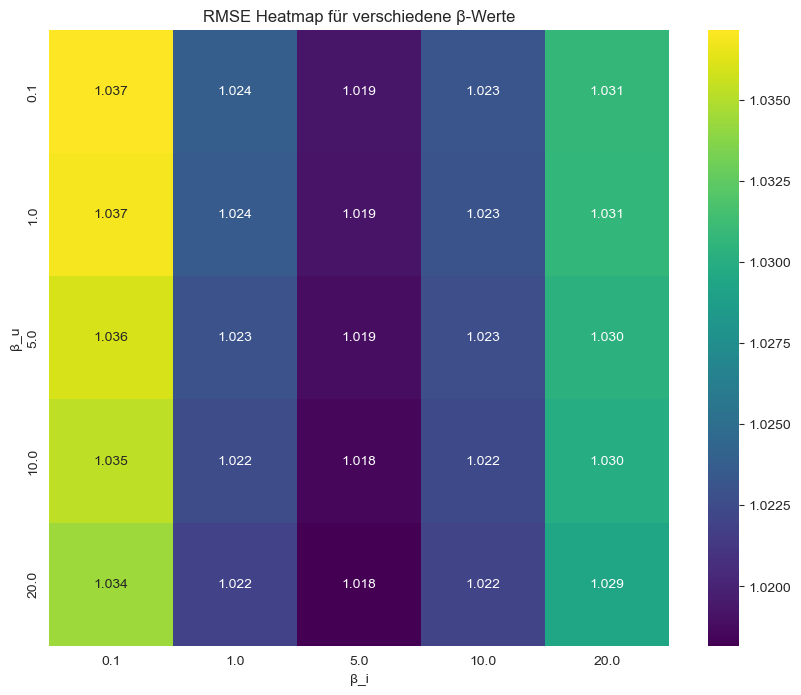

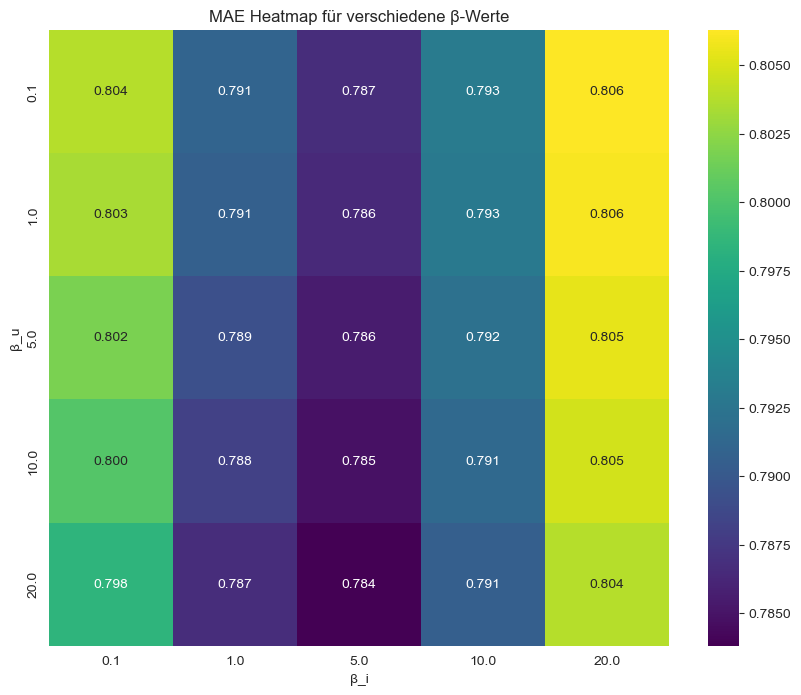

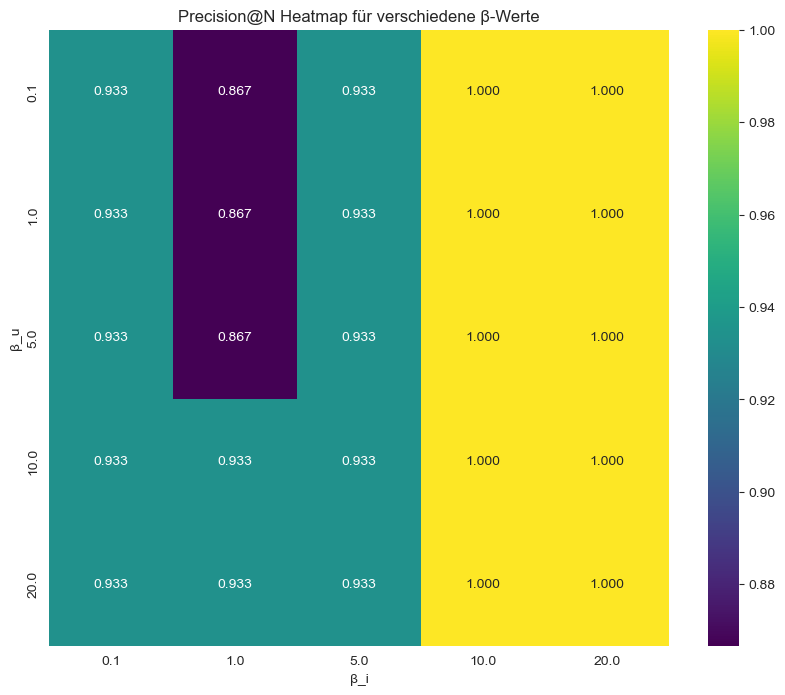

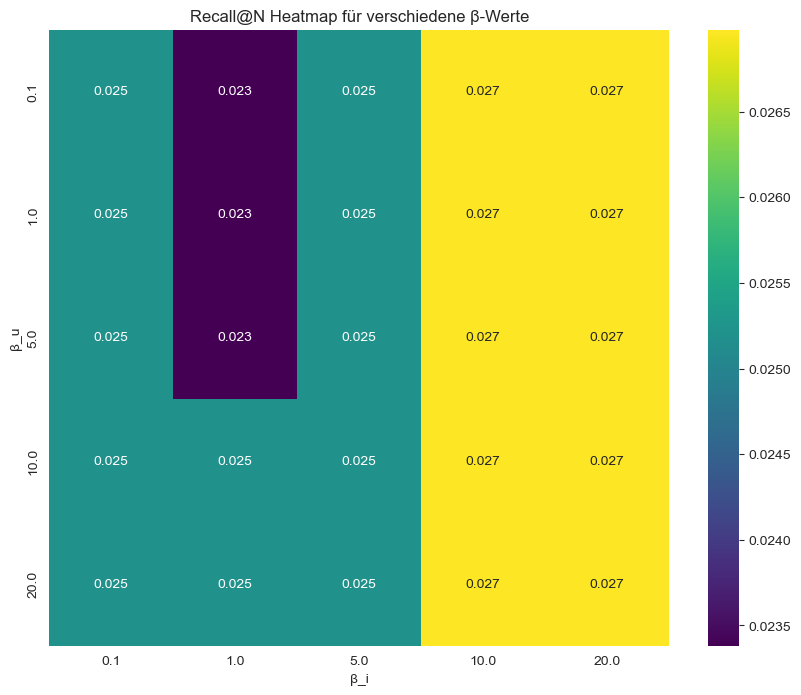

In [124]:
import time
#Grob testen der Betas
beta_values = [0.1, 1, 5, 10, 20]
rmse_list = []
mae_values = []
precision_values = []
recall_values = []

for beta_u in beta_values:
    for beta_i in beta_values:
        start_time = time.time()

        # Iteration auf 5 gesetzt, um einen Trend zu sehen
        mu, b_u, b_i = calculate_biases(train_set_1, beta_u=beta_u, beta_i=beta_i, iteration=3)

        end_time = time.time()

        # RMSE berechnen
        rmse = compute_rmse(mu, b_u, b_i, validate_masked_1)

        # MAE berechnen
        predictions = [mu + b_u.get(u, 0) + b_i.get(i, 0) for u, i in zip(validate_masked_1["userId"], validate_masked_1["movieId"])]
        true_ratings = validate_masked_1["rating"].values
        mae = mean_absolute_error(true_ratings, predictions)

        # Precision@N und Recall@N berechnen (falls relevant_items definiert ist)
        precision = precision_at_n(list(zip(validate_masked_1["movieId"], predictions)), relevant_items=validate_masked_1[["movieId", "rating"]].values)
        recall = recall_at_n(list(zip(validate_masked_1["movieId"], predictions)), relevant_items=validate_masked_1[["movieId", "rating"]].values)

        # Speichern der Ergebnisse
        rmse_list.append((beta_u, beta_i, rmse))
        mae_values.append((beta_u, beta_i, mae))
        precision_values.append((beta_u, beta_i, precision))
        recall_values.append((beta_u, beta_i, recall))

        print(f"β_u: {beta_u}, β_i: {beta_i}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, Precision@N: {precision:.4f}, Recall@N: {recall:.4f}, Dauer: {end_time - start_time:.1f} Sekunden")

# Ergebnisse in DataFrame umwandeln
df_results = pd.DataFrame(rmse_list, columns=["beta_u", "beta_i", "rmse"])
df_mae = pd.DataFrame(mae_values, columns=["beta_u", "beta_i", "mae"])
df_precision = pd.DataFrame(precision_values, columns=["beta_u", "beta_i", "precision"])
df_recall = pd.DataFrame(recall_values, columns=["beta_u", "beta_i", "recall"])

# RMSE Heatmap
pivot_rmse = df_results.pivot(index="beta_u", columns="beta_i", values="rmse")
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_rmse, annot=True, fmt=".3f", cmap="viridis")
plt.title("RMSE Heatmap für verschiedene β-Werte")
plt.xlabel("β_i")
plt.ylabel("β_u")
plt.show()

# MAE Heatmap
pivot_mae = df_mae.pivot(index="beta_u", columns="beta_i", values="mae")
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_mae, annot=True, fmt=".3f", cmap="viridis")
plt.title("MAE Heatmap für verschiedene β-Werte")
plt.xlabel("β_i")
plt.ylabel("β_u")
plt.show()

# Precision@N Heatmap
pivot_precision = df_precision.pivot(index="beta_u", columns="beta_i", values="precision")
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_precision, annot=True, fmt=".3f", cmap="viridis")
plt.title("Precision@N Heatmap für verschiedene β-Werte")
plt.xlabel("β_i")
plt.ylabel("β_u")
plt.show()

# Recall@N Heatmap
pivot_recall = df_recall.pivot(index="beta_u", columns="beta_i", values="recall")
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_recall, annot=True, fmt=".3f", cmap="viridis")
plt.title("Recall@N Heatmap für verschiedene β-Werte")
plt.xlabel("β_i")
plt.ylabel("β_u")
plt.show()

### Exercise 5 - Collaborative filtering; item-based and user-based (12 points)
In this exersise we will build several different collaborative-filtering RS based on nearest neighbour technique, both in terms of item and user. 

Implement:
1. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
2. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 
3. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
4. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 

Each should have a default $K$ of 30.

Explain how you handle NaN values in the user rating matrix when computing similarities? What other preparations are useful such as normalization and mean centering?

Describe the two similarity metrics.

Show the top 20 recommended items for user ids 3, 5 and 7.

# Umgang mit NaN-Werten

Ich ersetze die NaN-Werte in der Cosine Similarity (für sowohl Items als auch Users) mit 0, und zwar erst nachdem ich den Mittelwert pro Item bzw. User abgezogen habe. Dies stellt sicher, dass die Cosine Similarity-Funktion von scikit-learn korrekt berechnet werden kann, da diese Bibliothek keine NaN-Werte unterstützt. Bei der Pearson Similarity ersetze ich die NaN-Werte ebenfalls mit 0, allerdings nachdem ich die URM (User-Rating-Matrix) zentriert habe. Der Ersatz von NaN durch 0 ist eine pragmatische Lösung, da fehlende Bewertungen als „nicht vorhanden“ betrachtet werden, ohne den Berechnungsprozess zu stören.

In der Funktion predict_ratings_item_based und predict_ratings_user_based hingegen vermeide ich NaN-Werte direkt, indem ich alle NaN-Werte vorher mit dropna() entferne. Dadurch wird vermieden, dass fehlende Bewertungen den Vorhersageprozess beeinflussen, und es ist keine Notwendigkeit, NaN-Werte nachträglich zu ersetzen.

In [150]:
def create_urm(data, index, colums, values):
    return data.pivot(index=index, columns=colums, values=values)

urm = create_urm(training, "userId", "movieId", "rating")

## Cosine Similarity

Die Cosine Similarity misst die Ähnlichkeit zwischen zwei Items, indem sie den Winkel zwischen ihren Bewertungsvektoren betrachtet. Je kleiner der Winkel, desto ähnlicher sind die Items im Bewertungsschema der Nutzer.

Um Verzerrungen durch unterschiedliche Bewertungsskalen zu vermeiden – z.B. wenn einige Nutzer generell strenger oder grosszügiger bewerten – wird häufig ein Mean-Centering durchgeführt: Dabei wird von jeder Bewertung der Durchschnittswert des jeweiligen Items (oder Nutzers) abgezogen.

Dadurch vergleicht die Cosine Similarity nicht die absoluten Werte, sondern die Abweichungen vom Mittelwert, also das tatsächliche Bewertungsmuster. Das macht die Ähnlichkeitsberechnung robuster und aussagekräftiger.



In [151]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_items(matrix):
    # Mean-Centering pro Item
    item_means = matrix.mean(axis=0) #axis = 0 bedeutet den Mittelwert pro Spalte zu berechnen
    matrix_centered = matrix.sub(item_means, axis=1) # subtrahiert spaltenweise (axis = 1) den jeweiligen Mittelwert des Items ab

    return pd.DataFrame(
        cosine_similarity(np.nan_to_num(matrix_centered.T)),
        index=matrix.columns,
        columns=matrix.columns
    )

def cosine_similarity_users(matrix):
    # Mean-Centering pro User
    user_means = matrix.mean(axis=1) #axis = 1 bedeutet den Mittelwert pro Zeile zu berechnen
    matrix_centered = matrix.sub(user_means, axis=0) # subtrahiert zeilenweise (axis = 0) den jeweiligen Mittelwert des Users ab

    return pd.DataFrame(
        cosine_similarity(np.nan_to_num(matrix_centered)),
        index=matrix.index,
        columns=matrix.index
    )

## Pearson Similarity
Die Pearson Similarity misst die lineare Korrelation zwischen zwei Items oder Nutzern, basierend auf deren gemeinsamen Bewertungen. Sie betrachtet dabei nicht nur die Richtung der Bewertungen, sondern auch, ob hohe Bewertungen bei einem Item (bzw. Nutzer) mit hohen Bewertungen beim anderen einhergehen – unabhängig vom absoluten Bewertungsniveau.

Um individuelle Bewertungstendenzen auszugleichen, wird vor der Berechnung der Pearson Similarity ein Mean-Centering durchgeführt: Bei der Item-basierten Variante wird von jeder Bewertung der Mittelwert des jeweiligen Items abgezogen; bei der nutzerbasierten Variante erfolgt die Zentrierung zeilenweise, also pro Nutzer. So werden systematisch grosszügige oder strenge Bewertungsschemata normalisiert.

Anschliessend wird die Korrelation zwischen den zentrierten Vektoren berechnet. Da in der Praxis häufig nicht alle Nutzer alle Items bewerten, entstehen Lücken im Rating-Matrix – diese werden durch gezieltes Beibehalten oder Ersetzen von fehlenden Werten (NaN) berücksichtigt: Bei Items ignoriert pd.corr() diese NaN-Werte automatisch während der Korrelation; bei Nutzern hingegen werden sie nach dem Zentrieren direkt mit 0 ersetzt. Das sorgt für eine robuste Berechnung, selbst bei spärlich besetzten Daten.

In [152]:
def pearson_similarity_items(matrix):
    # Mittelwert zentrieren je Item (Spalte)
    centered_matrix = matrix.sub(matrix.mean(axis=0), axis=1)  # subtrahiert den Mittelwert pro Spalte (Item)
    
    # Pearson-Korrelation berechnen (ignoriere NaN-Werte während der Berechnung)
    similarity = centered_matrix.T.corr(method='pearson').fillna(0)  # Fülle NaN mit 0, falls keine gemeinsame Bewertung vorhanden
    return similarity

def pearson_similarity_users(matrix):
    # Mittelwert zentrieren je User (Zeile)
    centered = matrix.sub(matrix.mean(axis=1), axis=0).fillna(0)# subtrahiert zeilenweise den jeweiligen Mittelwert pro Zeile des Items ab und ersetzt anschliessend alle NA Werte mit 0
    # Jetzt Zeilen miteinander korrelieren (User-User-Similarity) und anschliessend die NA-Werte mit 0 ersetzen
    similarity = centered.T.corr().fillna(0)
    return similarity

## Prediction Item-Based

In [153]:
def predict_ratings_item_based(user_id, similarity_matrix, rating_matrix, k=30):
    # Zugreifen auf die korrekten user_ids und NaN entfernen
    user_ratings = rating_matrix.loc[user_id].dropna()

    scores = {}
    for item in rating_matrix.columns:
        if pd.notna(rating_matrix.at[user_id, item]):
            continue  # überspringe bereits bewertete Items
        
        # Wenn der Artikel nicht in der Similarity-Matrix existiert, überspringen
        if item not in similarity_matrix.columns:
            continue
        
        sims = similarity_matrix[item].drop(item).dropna()  # Entfernen des Vergleichs zum gleichen Item
        rated_sims = sims[user_ratings.index.intersection(sims.index)]  # Nur die Items, die der User bewertet hat
        top_k = rated_sims.sort_values(ascending=False).head(k)

        if top_k.empty:
            continue

        weighted_sum = np.dot(user_ratings[top_k.index], top_k)
        sim_sum = np.sum(np.abs(top_k))

        scores[item] = weighted_sum / sim_sum if sim_sum != 0 else np.nan

    return pd.Series(scores).dropna().sort_values(ascending=False)


### Top n item similatrity
Darf über 5

In [156]:
def print_top_n_item_similarity(user_ids: list, urm_, movies_df, method, n=20, k=30):
    movies_itembased = movies_df.set_index("movieId")
    all_movie_ids = urm_.columns

    # Ähnlichkeitsmatrix berechnen
    if method == "cosine":
        item_sim_matrix = cosine_similarity_items(urm_)
    elif method == "pearson":
        item_sim_matrix = pearson_similarity_items(urm_)
    else:
        print(f"Ungültige Methode: {method}. Erlaubt sind nur 'cosine' oder 'pearson'.")
        return

    for uid in user_ids:
        if uid in urm_.index:
            # User ist bekannt – Standard-Empfehlung basierend auf Item-Similarities
            recs = predict_ratings_item_based(uid, item_sim_matrix, urm_, k)
            top_n = recs.head(n)
        else:
            # Neuer/unbekannter User – Fallback: Top-N Items basierend auf globalem Durchschnitt
            global_avg_ratings = urm_.mean(axis=0)
            top_n = global_avg_ratings.sort_values(ascending=False).head(n)

        # Titel über movieId holen
        valid_movie_ids = top_n.index.intersection(movies_itembased.index)
        movie_titles = movies_itembased.loc[valid_movie_ids, "title"]

        results = pd.DataFrame({
            "Predicted Rating": top_n.loc[valid_movie_ids].values,
            "Movie Title": movie_titles.values
        })

        print(f"\nTop {n} Empfehlungen für User {uid} (Item-Based, {method}):")
        print(results.set_index("Movie Title"))

#### Cosine

In [157]:
print_top_n_item_similarity(user_ids = [3, 5, 7], urm_ = urm, movies_df = movies, method = "cosine")


Top 20 Empfehlungen für User 3 (Item-Based, cosine):
                                                    Predicted Rating
Movie Title                                                         
Red Sorghum (Hong gao liang) (1987)                              5.0
De platte jungle (1978)                                          5.0
Blue Planet II (2017)                                            5.0
Won't You Be My Neighbor? (2018)                                 5.0
Class, The (Klass) (2007)                                        5.0
Ex Drummer (2007)                                                5.0
Lesson Faust (1994)                                              5.0
Hollywood Shuffle (1987)                                         5.0
Reform School Girls (1986)                                       5.0
Che: Part Two (2008)                                             5.0
Che: Part One (2008)                                             5.0
Hunger (2008)                                    

#### Pearson

0.5 könnte falsch sein

In [132]:
print_top_n_item_similarity(user_ids = [3, 5, 7], urm_ = urm, movies_df = movies, method = "pearson")

KeyError: 3

## Prediction user-based

In [33]:
def predict_ratings_user_based(user_id, similarity_matrix, rating_matrix, k=30):
    #User selbst wurd entfertn da er nicht mit dsich verglichen werden soll
    sim_users = similarity_matrix[user_id].drop(user_id).dropna()
    #Welche top-k User sind mit Ursprung user Ähnlich
    top_k_users = sim_users.sort_values(ascending=False).head(k)
    
    # Mittels gewichtung wird der Ähnlcihste user gesucht
    weighted_sum = (rating_matrix.loc[top_k_users.index].T * top_k_users).T.sum()
    sim_sum = top_k_users.abs().sum()
    
    user_mean = rating_matrix.loc[user_id].mean()
    predicted_ratings = user_mean + (weighted_sum / sim_sum) #Addiert den in der Similarity abgezogenen Mittelwert wieder drauf
    
    predicted_ratings = predicted_ratings.clip(lower=0.5, upper=5) #Definiert den Werte bereich

    return predicted_ratings

In [34]:
def print_top_n_user_similarity(user_ids: list, urm_, movies_df, method, n = 20, k = 30):
    movies_user = movies_df.set_index("movieId")
    if method == "cosine":
        user_sim_matrix = cosine_similarity_users(urm_)
    elif method == "pearson":
        user_sim_matrix = pearson_similarity_users(urm_)
    else:
        print(f"Die Methode ist nicht vorhanden – bitte 'cosine' oder 'pearson' verwenden (nicht '{method}').")
        return

    for uid in user_ids:
        # Vorhersage der Bewertungen für alle Filme für diesen User
        recs = predict_ratings_user_based(uid, user_sim_matrix, urm_, k)
        #Top-n Filme auswählen
        top_n = recs.head(n)
        
        # Robuster Fix: Index-Typen anpassen + nur gültige MovieIDs verwenden
        top_n.index = top_n.index.astype(movies_user.index.dtype) #Typenübereinstimmung
        valid_ids = top_n.index[top_n.index.isin(movies_user.index)] #ungültige Filme entfernen
        top_n = top_n.loc[valid_ids] #nur gültige ID
        movie_titles = movies_user.loc[valid_ids, "title"] #Filmtitel antatt movie_ID anzeigen
        
        # Runden auf das nächste 0.5
        rounded_ratings = np.round(top_n.values * 2) / 2
        
        results = pd.DataFrame({
            "Predicted Rating": rounded_ratings,
            "Movie Title": movie_titles.values
        })

        print(f"\nTop {n} Empfehlungen für User {uid} (User-based, {method}):")
        print(results.set_index("Movie Title"))

In [35]:
print_top_n_user_similarity(user_ids = [3, 5, 7], urm_ = urm, movies_df = movies, method = "cosine")


Top 20 Empfehlungen für User 3 (User-based, cosine):
                                       Predicted Rating
Movie Title                                            
Toy Story (1995)                                    2.5
Jumanji (1995)                                      2.5
Grumpier Old Men (1995)                             2.5
Waiting to Exhale (1995)                            2.5
Father of the Bride Part II (1995)                  2.5
Heat (1995)                                         3.0
Sabrina (1995)                                      2.5
Tom and Huck (1995)                                 2.5
Sudden Death (1995)                                 2.5
GoldenEye (1995)                                    3.5
American President, The (1995)                      2.5
Dracula: Dead and Loving It (1995)                  2.5
Balto (1995)                                        2.5
Nixon (1995)                                        2.5
Cutthroat Island (1995)                           

In [36]:
print_top_n_user_similarity(user_ids = [3, 5, 7], urm_ = urm, movies_df = movies, method = "pearson")


Top 20 Empfehlungen für User 3 (User-based, pearson):
                                       Predicted Rating
Movie Title                                            
Toy Story (1995)                                    2.5
Jumanji (1995)                                      2.5
Grumpier Old Men (1995)                             2.5
Waiting to Exhale (1995)                            2.5
Father of the Bride Part II (1995)                  2.5
Heat (1995)                                         3.0
Sabrina (1995)                                      2.5
Tom and Huck (1995)                                 2.5
Sudden Death (1995)                                 2.5
GoldenEye (1995)                                    3.5
American President, The (1995)                      2.5
Dracula: Dead and Loving It (1995)                  2.5
Balto (1995)                                        2.5
Nixon (1995)                                        2.5
Cutthroat Island (1995)                          


### Exercise 6 - Optimize hyperparameter $K$ (6 points)
Optimize the hyperparameter $K$ for all RS from the prior exercise optimizing for minimal RMSE. 
For each RS plot RMSE, Precision@N and Recall@N as a function of $K$. 

Compare the results of these four RS on the 3 example users. Do the results match your expectation? Describe.

In [37]:
def evaluate_recommender(predict_function, test_df, train_df, k_values, N=15, user_subset=None):
    results = {}

    users = user_subset if user_subset is not None else test_df["userId"].unique()

    for k in k_values:
        all_precisions = []
        all_recalls = []
        all_rmses = []

        for uid in users:
            try:
                user_data = test_df[test_df["userId"] == uid]
                relevant_items = list(zip(user_data["movieId"], user_data["rating"]))

                predictions = predict_function(uid, train_df, k)

                if predictions.empty:
                    continue

                # Precision & Recall
                pred_list = list(predictions.sort_values(ascending=False).items())
                prec = precision_at_n(pred_list, relevant_items, N)
                rec = recall_at_n(pred_list, relevant_items, N)
                all_precisions.append(prec)
                all_recalls.append(rec)

                # RMSE (nur wenn Item in prediction enthalten)
                y_true, y_pred = [], []
                for mid, true_rating in relevant_items:
                    if mid in predictions:
                        y_true.append(true_rating)
                        y_pred.append(predictions[mid])

                if y_true:
                    rmse = root_mean_square_error(y_true, y_pred)
                    all_rmses.append(rmse)

            except Exception as e:
                print(f"Fehler bei User {uid}: {e}")

        results[k] = {
            "rmse": np.mean(all_rmses) if all_rmses else 0,
            "precision": np.mean(all_precisions) if all_precisions else 0,
            "recall": np.mean(all_recalls) if all_recalls else 0
        }

    return results

In [ ]:
from collections import defaultdict

def evaluate_recommender(predict_function, test_df, train_df, k_values, N=15):
    results = defaultdict(lambda: {"rmse": [], "precision": [], "recall": []})
    test_users = test_df["userId"].unique()

    for k in k_values:
        all_preds = []
        all_truths = []
        all_prec = []
        all_rec = []

        for uid in test_users:
            user_data = test_df[test_df["userId"] == uid]
            for _, row in user_data.iterrows():
                pred = predict_function(uid, train_df, k, single_item=row["movieId"])
                if pred is not None:
                    all_preds.append(pred)
                    all_truths.append(row["rating"])

            # Top-N Evaluation (nur einmal pro User)
            top_n_preds = predict_function(uid, train_df, k, N=N)
            relevant = user_data[["movieId", "rating"]].values.tolist()

            prec = precision_at_n(top_n_preds, relevant, N)
            rec = recall_at_n(top_n_preds, relevant, N)

            all_prec.append(prec)
            all_rec.append(rec)

        rmse = root_mean_square_error(all_truths, all_preds)
        precision = np.mean(all_prec)
        recall = np.mean(all_rec)

        results[k]["rmse"] = rmse
        results[k]["precision"] = precision
        results[k]["recall"] = recall

    return results


In [38]:
def predict_ratings_user_based(user_id, similarity_matrix, rating_matrix, k=30):
    if user_id not in similarity_matrix.index:
        return pd.Series(dtype=float)

    sim_users = similarity_matrix.loc[user_id].drop(user_id).dropna()
    top_k_users = sim_users.sort_values(ascending=False).head(k)
    
    if top_k_users.empty:
        return pd.Series(dtype=float)

    weighted_sum = (rating_matrix.loc[top_k_users.index].T * top_k_users).T.sum()
    sim_sum = top_k_users.abs().sum()
    
    user_mean = rating_matrix.loc[user_id].mean()
    predicted_ratings = user_mean + (weighted_sum / sim_sum)
    predicted_ratings = predicted_ratings.clip(lower=0.5, upper=5)

    return predicted_ratings


In [39]:
def root_mean_square_error(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

def precision_at_n(predictions, relevant_items, N=15, threshold=4.0):
    relevant_items = [item for item in relevant_items if item[1] >= threshold]
    top_n_predictions = predictions[:N]
    relevant_in_top_n = sum(1 for item in top_n_predictions if item[0] in [x[0] for x in relevant_items])
    return relevant_in_top_n / N if N > 0 else 0

def recall_at_n(predictions, relevant_items, N=15, threshold=4.0):
    relevant_items = [item for item in relevant_items if item[1] >= threshold]
    top_n_predictions = predictions[:N]
    relevant_in_top_n = sum(1 for item in top_n_predictions if item[0] in [x[0] for x in relevant_items])
    return relevant_in_top_n / len(relevant_items) if len(relevant_items) > 0 else 0


In [40]:
def wrapper_user_cosine(user_id, train_df, K, single_item=None, N=15):
    urm = create_urm(train_df, "userId", "movieId", "rating")
    sim_matrix = cosine_similarity_users(urm)

    if user_id not in sim_matrix.index:
        return None if single_item else []

    scores = predict_ratings_user_based(user_id, sim_matrix, urm, K)

    if single_item:
        return scores.get(single_item, None)
    else:
        return list(scores.sort_values(ascending=False).head(N).items())


In [41]:
def wrapper_user_pearson(user_id, train_df, K, single_item=None, N=15):
    urm = create_urm(train_df, "userId", "movieId", "rating")
    sim_matrix = pearson_similarity_users(urm)

    if single_item:
        scores = predict_ratings_user_based(user_id, sim_matrix, urm, K)
        return scores.get(single_item, None)
    else:
        scores = predict_ratings_user_based(user_id, sim_matrix, urm, K)
        return list(scores.sort_values(ascending=False).head(N).items())


In [42]:
def wrapper_item_cosine(user_id, train_df, K, single_item=None, N=15):
    urm = create_urm(train_df, "userId", "movieId", "rating")
    sim_matrix = cosine_similarity_items(urm)

    if single_item:
        scores = predict_ratings_item_based(user_id, sim_matrix, urm, K)
        return scores.get(single_item, None)
    else:
        scores = predict_ratings_item_based(user_id, sim_matrix, urm, K)
        return list(scores.head(N).items())


In [43]:
def wrapper_item_pearson(user_id, train_df, K, single_item=None, N=15):
    urm = create_urm(train_df, "userId", "movieId", "rating")
    sim_matrix = pearson_similarity_items(urm)

    if single_item:
        scores = predict_ratings_item_based(user_id, sim_matrix, urm, K)
        return scores.get(single_item, None)
    else:
        scores = predict_ratings_item_based(user_id, sim_matrix, urm, K)
        return list(scores.head(N).items())


In [44]:
k_values = [5, 10, 20, 30, 50]
user_subset = [3, 5, 7]

results_uc = evaluate_recommender(wrapper_user_cosine, validation_set_1, training, k_values, user_subset = [3, 5, 7])
print("uc done)")
results_up = evaluate_recommender(wrapper_user_pearson, validation_set_1, training, k_values, user_subset = [3, 5, 7])
print("up")
results_ic = evaluate_recommender(wrapper_item_cosine, validation_set_1, training, k_values, user_subset = [3, 5, 7])
print("ic")
results_ip = evaluate_recommender(wrapper_item_pearson, validation_set_1, training, k_values, user_subset = [3, 5, 7])


Fehler bei User 3: 'list' object has no attribute 'empty'
Fehler bei User 5: 'list' object has no attribute 'empty'
Fehler bei User 7: 'list' object has no attribute 'empty'
Fehler bei User 3: 'list' object has no attribute 'empty'
Fehler bei User 5: 'list' object has no attribute 'empty'
Fehler bei User 7: 'list' object has no attribute 'empty'
Fehler bei User 3: 'list' object has no attribute 'empty'
Fehler bei User 5: 'list' object has no attribute 'empty'
Fehler bei User 7: 'list' object has no attribute 'empty'
Fehler bei User 3: 'list' object has no attribute 'empty'
Fehler bei User 5: 'list' object has no attribute 'empty'
Fehler bei User 7: 'list' object has no attribute 'empty'
Fehler bei User 3: 'list' object has no attribute 'empty'
Fehler bei User 5: 'list' object has no attribute 'empty'
Fehler bei User 7: 'list' object has no attribute 'empty'
uc done)
Fehler bei User 3: 'list' object has no attribute 'empty'
Fehler bei User 5: 'list' object has no attribute 'empty'
Fehle

In [45]:
def plot_metrics(results_dict, title_prefix=""):
    ks = list(results_dict.keys())
    rmse = [results_dict[k]["rmse"] for k in ks]
    precision = [results_dict[k]["precision"] for k in ks]
    recall = [results_dict[k]["recall"] for k in ks]

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(ks, rmse, marker='o')
    plt.title(f"{title_prefix} RMSE")
    plt.xlabel("K")
    plt.ylabel("RMSE")

    plt.subplot(1, 3, 2)
    plt.plot(ks, precision, marker='o')
    plt.title(f"{title_prefix} Precision@N")
    plt.xlabel("K")
    plt.ylabel("Precision")

    plt.subplot(1, 3, 3)
    plt.plot(ks, recall, marker='o')
    plt.title(f"{title_prefix} Recall@N")
    plt.xlabel("K")
    plt.ylabel("Recall")

    plt.tight_layout()
    plt.show()

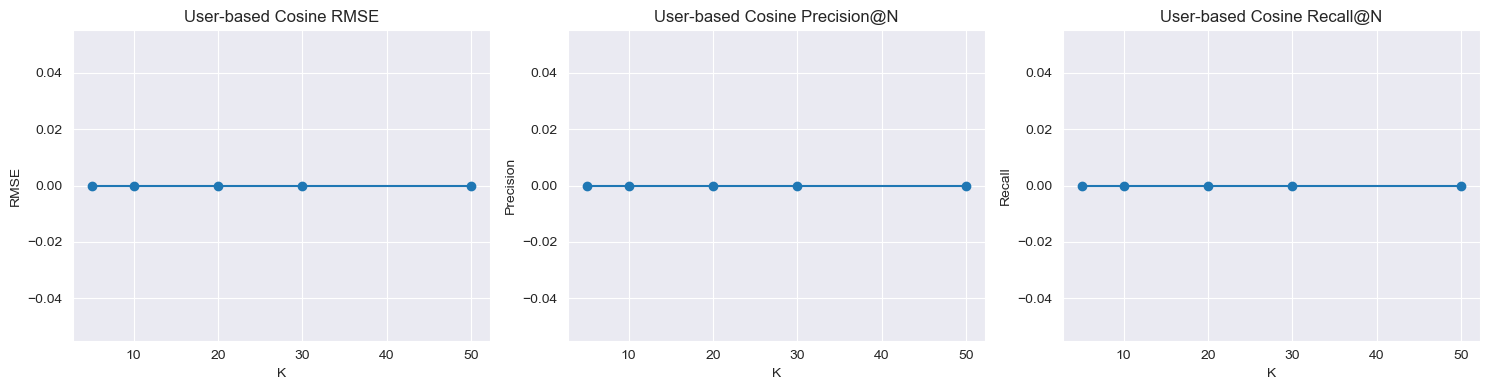

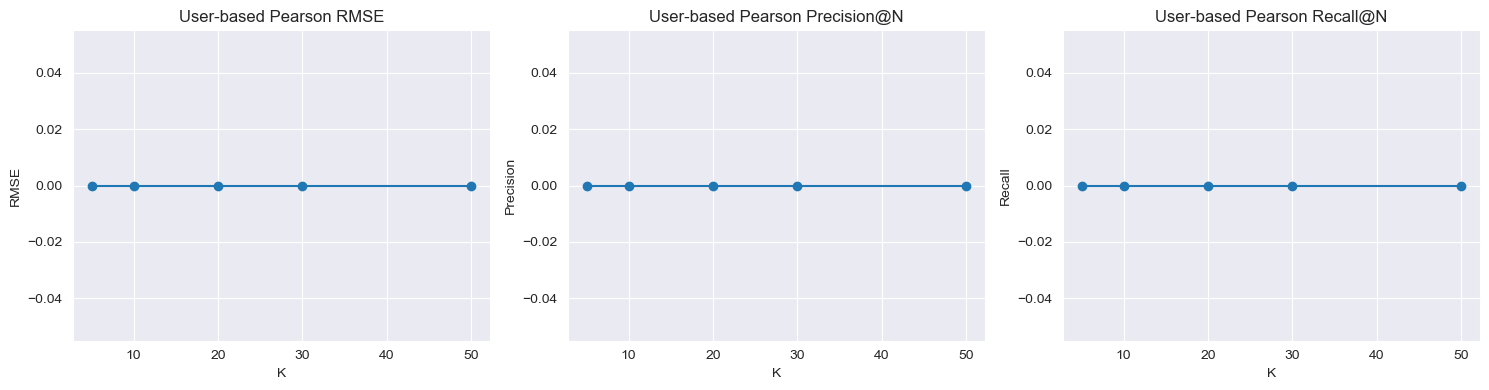

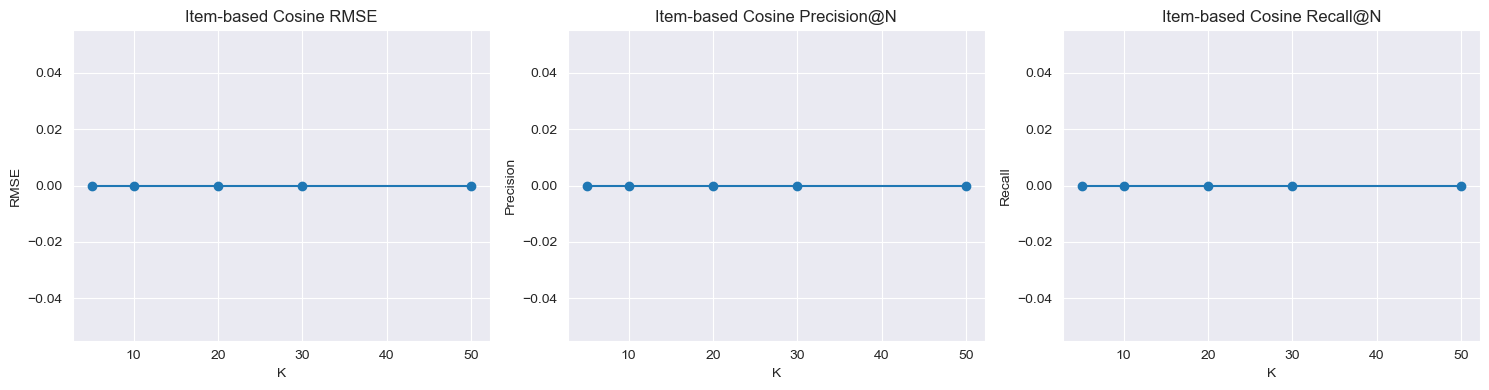

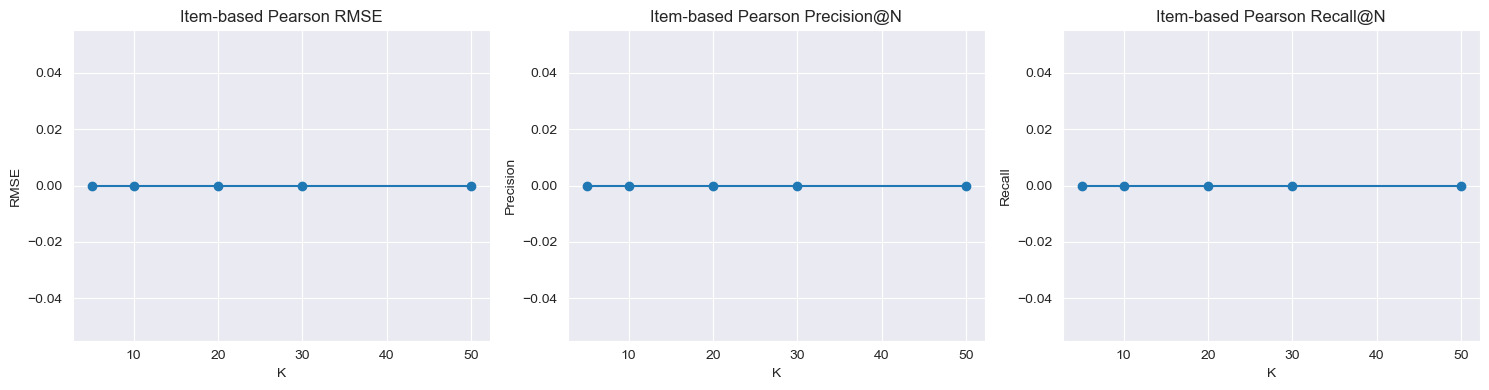

In [46]:
plot_metrics(results_uc, "User-based Cosine")
plot_metrics(results_up, "User-based Pearson")
plot_metrics(results_ic, "Item-based Cosine")
plot_metrics(results_ip, "Item-based Pearson")

### Exercise 7 - Model-based RS: SVD (10 points)
In this exercise we will use the unsupervised method *singular value decomposition (SVD)* from the python package *surprise* (https://surpriselib.com, documentation https://surprise.readthedocs.io/en/stable/matrix_factorization.html). SVD can compress much of the information of a matrix in few components.  

a)Run the SVD RS and show the results on the three example users from exercise 2. Explain how this algorithm works.

Note: A very good general introduction to SVD is this youtube video series starting with https://www.youtube.com/watch?v=gXbThCXjZFM&t=337s . See *Collaborative filtering recommender systems* by Ekstrand et al. *Mining of massive datasets* by Leskovec, Kapitel 11 (2020) and, *Recommender systems: The textbook*, by Aggarwal, chapter 3

b) We explore now what latent factors SVD has learned. Generate three sorted lists: Sort the items by their biggest, second biggest and third biggest singlular value component. For each list print the top and bottom 20 items. What do you observe?

### Exercise 8 - Optimize hyperparameter $k$ or `n_factors` (4 points)
Optimize the hyperparameter, representing the number of greatest SVD components used for the truncated reconstruction of the user item matrix, to minimize RMSE.
Plot RMSE, Precision@N and Recall@N as a function of this hyperparameter. Finally output all performance metrics from exercise 3 for the optimal $k$ value.

### Exercise 9 - Everything goes (30 points)
In this exercise you can explore different methods of RS. You are not limited what methods you apply. You can try to improve the methods from the earlier exercises by modifiying them or generating ensemble or hybrid RS. Also you could train deep neural networks, use NLP methods, use the available links to imdb available in the dataset to further enrich the dataset or find an obscure method by someone else on Github. 
Document what your inspirations and sources are and describe the method conceptually. 

**Build and optimize in total *three* different methods. The last one has the additional requirement that it should increase the diversity of the recommendations in order to minimize filter bubbles.**

**Important: If you use the work of someone else you must be able to explain the method conceptually during the defense MSP.** 

Output the performance metrics of exercise 3. 

### Exercise 10 - Compare all RS that you build in this challenge (8 points)
a) Compile a table with the performance metrics of exercise 3 for all RS from this MC (Make sure to include the baseline RS and random RS) on the test set defined in exercise 3. Also generate comparative plots. Discuss.

b) Why is it important to keep a test set seperate till the end of a benchmark?

**Read the Guidelines for Implementation and Submission one more time.**